In [212]:
data_dir = "SagSolDataset"

In [213]:
import os
os.listdir(data_dir)

['Sagadonulmez', 'Sol', 'Sag', 'Soladonulmez']

In [214]:
for cls in os.listdir(data_dir):
  print(cls, ":", len(os.listdir(data_dir + "/" + cls)))

Sagadonulmez : 371
Sol : 371
Sag : 371
Soladonulmez : 371


In [215]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir)
len(dataset)

1484

In [216]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=95x89 at 0x7FD7B00CDE80>, 0)

In [217]:
dataset.classes

['Sag', 'Sagadonulmez', 'Sol', 'Soladonulmez']

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline

0


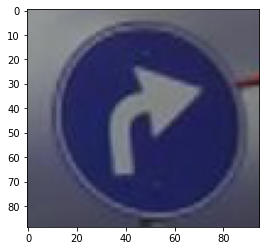

In [219]:
img, label = dataset[0]
plt.imshow(img)
print(label)

In [220]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([
    tt.Resize(32),
    tt.RandomCrop(32),
    tt.ColorJitter(brightness=0.5),
    tt.ToTensor()
]))

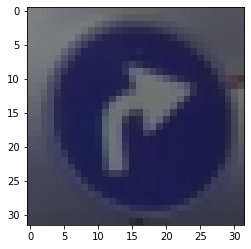

In [221]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))

In [222]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(1336, 148)

In [223]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(1336, 148)

In [224]:
from torch.utils.data import DataLoader

batch_size = 32

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers=3,
                      pin_memory=True)

In [225]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(18,18))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

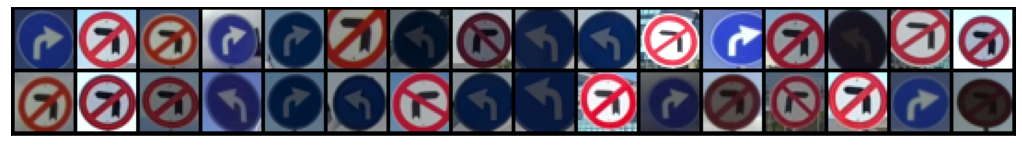

In [226]:
show_batch(train_dl)

In [227]:
import torch 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [228]:
torch.cuda.is_available()

True

In [229]:
device = get_default_device()
device

device(type='cuda')

In [230]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [231]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    """Calculate loss for a batch of traning data"""
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    """Calculate loss & accuracy for a batch of validation data"""
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss":loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [232]:
"Evaluates the model's performance on the validation set"
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [233]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.sigmoid = nn.Sigmoid()
        self.conv1 = conv_block(in_channels, 32)
        self.conv2 = conv_block(32, 16, pool=True) # 1  
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(16, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.classifier(out)
        return out

In [236]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [237]:
for batch in train_dl:
  images, labels = batch
  print("images.shape", images.shape)
  print("images.device", images.device)
  preds = model(images)
  print("preds.shape", preds.shape)
  break

images.shape torch.Size([32, 3, 32, 32])
images.device cuda:0
preds.shape torch.Size([32, 4])


In [238]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.3919384479522705, 'val_acc': 0.21375000476837158}]

In [239]:
history += fit(10, 0.01, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.0675, val_loss: 0.7102, val_acc: 0.7962
Epoch [1], train_loss: 0.5956, val_loss: 0.4014, val_acc: 0.9175
Epoch [2], train_loss: 0.4343, val_loss: 0.2655, val_acc: 0.9150
Epoch [3], train_loss: 0.3242, val_loss: 0.2618, val_acc: 0.8825
Epoch [4], train_loss: 0.2998, val_loss: 0.1713, val_acc: 0.9488
Epoch [5], train_loss: 0.2245, val_loss: 0.1181, val_acc: 0.9525
Epoch [6], train_loss: 0.2152, val_loss: 0.1272, val_acc: 0.9712
Epoch [7], train_loss: 0.2014, val_loss: 0.2365, val_acc: 0.8825
Epoch [8], train_loss: 0.1791, val_loss: 0.2514, val_acc: 0.8675
Epoch [9], train_loss: 0.1825, val_loss: 0.0722, val_acc: 0.9775


In [240]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.1215, val_loss: 0.0487, val_acc: 0.9937
Epoch [1], train_loss: 0.1032, val_loss: 0.0492, val_acc: 0.9937
Epoch [2], train_loss: 0.0966, val_loss: 0.0421, val_acc: 0.9875
Epoch [3], train_loss: 0.0932, val_loss: 0.0499, val_acc: 0.9775
Epoch [4], train_loss: 0.0810, val_loss: 0.0374, val_acc: 0.9937


In [241]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

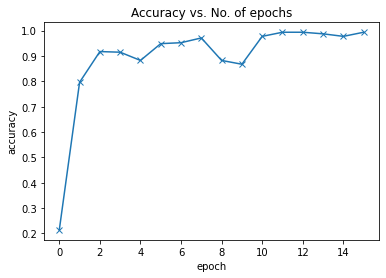

In [242]:
plot_accuracies(history)

In [243]:
torch.save(model,'sagsolpytorch.h5')

In [244]:
loaded_model = torch.load('sagsolpytorch.h5')

In [259]:
import cv2
img = cv2.imread("28.jpg")
img = cv2.resize(img, (32, 32))
img = torch.from_numpy(img).permute(2, 0, 1)
img = img.unsqueeze(0)
img = img.float()
pred = loaded_model(img.to("cuda"))
pred

tensor([[-2720.8667,   784.5276,  -431.2908,  2097.5034]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [260]:
import numpy as np
pred = torch.max(torch.abs(pred), dim=1)

In [267]:
int(pred.indices[0])

0